In [36]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

import optuna#载入optuna优化包

device = torch.device("cpu")

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
###########训练数据
xtrain = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1).to(device)
ytrain = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)  # 这里是污染数据固定不变当成训练数据
#噪声注入输入数据方法

#测试数据
SEED = 4321
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

ytest = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)

In [37]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数
#这里把Net Class放在循环外面，对于不同的噪声注入数据，采用net.reset_parameters()对于网络进行重置

net = Net(n_feature=1, n_hidden1=10, n_output=1)#定义1*10*1的网络
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96
loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse

In [38]:
# 定义神经网络训练代码
from tqdm import tqdm

NJnum = 30
epoch = 20000

inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)


def train_net(sigma):
    output = torch.zeros(inputx.shape).to(device)  # 在函数内部初始化 output
    sigma = sigma
    
    output.zero_()  # 清零张量
    for num in range(NJnum):
        SEED = 1234 + 12 * num  
        np.random.seed(SEED)
        random.seed(SEED) 

        x_noisy = (xtrain + sigma * torch.randn(xtrain.size())).to(device)
        
        net.reset_parameters()
        
        for t in range(epoch):
            prediction = net(x_noisy)
            loss = loss_func(prediction, ytrain)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tqdm.write(f'NJnum {num}/{NJnum}, loss: {loss.item():.4f}')
        
        response = net(inputx)
        output += response  # 将每个 response 累加
    
    # 将张量除以 NJnum
    output /= NJnum# 计算平均输出，看成噪声扰动的网络输出
    # 泛化误差
    losstest = loss_func(ytest,output[::20])
    return losstest


def objective(trial):
    sigma = trial.suggest_float("sigma", 0.0, 0.6)
    losstest = train_net(sigma)
    return losstest

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
for trial in study.trials:
    print(f"Trial {trial.number}: Value = {trial.value}")
# 输出结果
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-15 22:23:06,185] A new study created in memory with name: no-name-44e83474-5813-47b5-8a7e-4cb594f10803


NJnum 0/30, loss: 0.0189
NJnum 1/30, loss: 0.0956
NJnum 2/30, loss: 0.0057
NJnum 3/30, loss: 0.0130
NJnum 4/30, loss: 0.0231
NJnum 5/30, loss: 0.0218
NJnum 6/30, loss: 0.0136
NJnum 7/30, loss: 0.0137
NJnum 8/30, loss: 0.0033
NJnum 9/30, loss: 0.0281
NJnum 10/30, loss: 0.0310
NJnum 11/30, loss: 0.0587
NJnum 12/30, loss: 0.0258
NJnum 13/30, loss: 0.0464
NJnum 14/30, loss: 0.0122
NJnum 15/30, loss: 0.1245
NJnum 16/30, loss: 0.0215
NJnum 17/30, loss: 0.0410
NJnum 18/30, loss: 0.0040
NJnum 19/30, loss: 0.0744
NJnum 20/30, loss: 0.0227
NJnum 21/30, loss: 0.0882
NJnum 22/30, loss: 0.0120
NJnum 23/30, loss: 0.0101
NJnum 24/30, loss: 0.0338
NJnum 25/30, loss: 0.0109
NJnum 26/30, loss: 0.0212
NJnum 27/30, loss: 0.0228
NJnum 28/30, loss: 0.0400


[I 2024-03-15 22:28:13,448] Trial 0 finished with value: 0.13931620121002197 and parameters: {'sigma': 0.23182644666705954}. Best is trial 0 with value: 0.13931620121002197.


NJnum 29/30, loss: 0.0580
NJnum 0/30, loss: 0.0371
NJnum 1/30, loss: 0.0170
NJnum 2/30, loss: 0.0047
NJnum 3/30, loss: 0.0077
NJnum 4/30, loss: 0.0576
NJnum 5/30, loss: 0.0152
NJnum 6/30, loss: 0.0000
NJnum 7/30, loss: 0.0365
NJnum 8/30, loss: 0.0246
NJnum 9/30, loss: 0.0048
NJnum 10/30, loss: 0.0057
NJnum 11/30, loss: 0.0953
NJnum 12/30, loss: 0.0103
NJnum 13/30, loss: 0.0316
NJnum 14/30, loss: 0.0327
NJnum 15/30, loss: 0.0146
NJnum 16/30, loss: 0.0160
NJnum 17/30, loss: 0.0177
NJnum 18/30, loss: 0.0161
NJnum 19/30, loss: 0.0008
NJnum 20/30, loss: 0.0288
NJnum 21/30, loss: 0.0074
NJnum 22/30, loss: 0.0120
NJnum 23/30, loss: 0.0042
NJnum 24/30, loss: 0.0045
NJnum 25/30, loss: 0.0116
NJnum 26/30, loss: 0.0001
NJnum 27/30, loss: 0.0289
NJnum 28/30, loss: 0.0888


[I 2024-03-15 22:33:44,136] Trial 1 finished with value: 0.13706278800964355 and parameters: {'sigma': 0.20113567739126367}. Best is trial 1 with value: 0.13706278800964355.


NJnum 29/30, loss: 0.0731
NJnum 0/30, loss: 0.0473
NJnum 1/30, loss: 0.0097
NJnum 2/30, loss: 0.0140
NJnum 3/30, loss: 0.0043
NJnum 4/30, loss: 0.0684
NJnum 5/30, loss: 0.0441
NJnum 6/30, loss: 0.0387
NJnum 7/30, loss: 0.0379
NJnum 8/30, loss: 0.0061
NJnum 9/30, loss: 0.0341
NJnum 10/30, loss: 0.0378
NJnum 11/30, loss: 0.0376
NJnum 12/30, loss: 0.0876
NJnum 13/30, loss: 0.0110
NJnum 14/30, loss: 0.0537
NJnum 15/30, loss: 0.1989
NJnum 16/30, loss: 0.0239
NJnum 17/30, loss: 0.0354
NJnum 18/30, loss: 0.0257
NJnum 19/30, loss: 0.0532
NJnum 20/30, loss: 0.0371
NJnum 21/30, loss: 0.0292
NJnum 22/30, loss: 0.0466
NJnum 23/30, loss: 0.0725
NJnum 24/30, loss: 0.0324
NJnum 25/30, loss: 0.0127
NJnum 26/30, loss: 0.0337
NJnum 27/30, loss: 0.0100
NJnum 28/30, loss: 0.0015


[I 2024-03-15 22:39:17,703] Trial 2 finished with value: 0.2076692134141922 and parameters: {'sigma': 0.25623310246003217}. Best is trial 1 with value: 0.13706278800964355.


NJnum 29/30, loss: 0.0553
NJnum 0/30, loss: 0.0119
NJnum 1/30, loss: 0.0046
NJnum 2/30, loss: 0.0925
NJnum 3/30, loss: 0.2413
NJnum 4/30, loss: 0.0192
NJnum 5/30, loss: 0.0058
NJnum 6/30, loss: 0.0538
NJnum 7/30, loss: 0.0956
NJnum 8/30, loss: 0.1261
NJnum 9/30, loss: 0.0259
NJnum 10/30, loss: 0.1051
NJnum 11/30, loss: 0.0062
NJnum 12/30, loss: 0.0741
NJnum 13/30, loss: 0.0150
NJnum 14/30, loss: 0.0318
NJnum 15/30, loss: 0.0133
NJnum 16/30, loss: 0.0439
NJnum 17/30, loss: 0.1462
NJnum 18/30, loss: 0.0766
NJnum 19/30, loss: 0.0192
NJnum 20/30, loss: 0.0334
NJnum 21/30, loss: 0.0371
NJnum 22/30, loss: 0.0173
NJnum 23/30, loss: 0.1183
NJnum 24/30, loss: 0.0032
NJnum 25/30, loss: 0.0558
NJnum 26/30, loss: 0.0664
NJnum 27/30, loss: 0.1302
NJnum 28/30, loss: 0.0299


[I 2024-03-15 22:45:17,859] Trial 3 finished with value: 0.3702355921268463 and parameters: {'sigma': 0.5498378161981383}. Best is trial 1 with value: 0.13706278800964355.


NJnum 29/30, loss: 0.0280
NJnum 0/30, loss: 0.0331
NJnum 1/30, loss: 0.0350
NJnum 2/30, loss: 0.0337
NJnum 3/30, loss: 0.0282
NJnum 4/30, loss: 0.0330
NJnum 5/30, loss: 0.0862
NJnum 6/30, loss: 0.0076
NJnum 7/30, loss: 0.0016
NJnum 8/30, loss: 0.0663
NJnum 9/30, loss: 0.1453
NJnum 10/30, loss: 0.1427
NJnum 11/30, loss: 0.0972
NJnum 12/30, loss: 0.0814
NJnum 13/30, loss: 0.0350
NJnum 14/30, loss: 0.0981
NJnum 15/30, loss: 0.0706
NJnum 16/30, loss: 0.0088
NJnum 17/30, loss: 0.0102
NJnum 18/30, loss: 0.0876
NJnum 19/30, loss: 0.0265
NJnum 20/30, loss: 0.0481
NJnum 21/30, loss: 0.0036
NJnum 22/30, loss: 0.0972
NJnum 23/30, loss: 0.0907
NJnum 24/30, loss: 0.0253
NJnum 25/30, loss: 0.0481
NJnum 26/30, loss: 0.0263
NJnum 27/30, loss: 0.0001
NJnum 28/30, loss: 0.0210


[I 2024-03-15 22:51:21,594] Trial 4 finished with value: 0.6875336170196533 and parameters: {'sigma': 0.5911307682989764}. Best is trial 1 with value: 0.13706278800964355.


NJnum 29/30, loss: 0.0765
NJnum 0/30, loss: 0.0356
NJnum 1/30, loss: 0.0026
NJnum 2/30, loss: 0.0279
NJnum 3/30, loss: 0.0069
NJnum 4/30, loss: 0.0311
NJnum 5/30, loss: 0.1251
NJnum 6/30, loss: 0.0205
NJnum 7/30, loss: 0.0145
NJnum 8/30, loss: 0.0506
NJnum 9/30, loss: 0.0157
NJnum 10/30, loss: 0.0151
NJnum 11/30, loss: 0.0431
NJnum 12/30, loss: 0.0360
NJnum 13/30, loss: 0.0376
NJnum 14/30, loss: 0.0260
NJnum 15/30, loss: 0.0098
NJnum 16/30, loss: 0.0101
NJnum 17/30, loss: 0.0296
NJnum 18/30, loss: 0.0304
NJnum 19/30, loss: 0.0164
NJnum 20/30, loss: 0.0805
NJnum 21/30, loss: 0.1072
NJnum 22/30, loss: 0.0674
NJnum 23/30, loss: 0.0106
NJnum 24/30, loss: 0.0311
NJnum 25/30, loss: 0.0098
NJnum 26/30, loss: 0.0150
NJnum 27/30, loss: 0.0332
NJnum 28/30, loss: 0.0579


[I 2024-03-15 22:56:54,464] Trial 5 finished with value: 0.30657172203063965 and parameters: {'sigma': 0.21650809055303966}. Best is trial 1 with value: 0.13706278800964355.


NJnum 29/30, loss: 0.0573
NJnum 0/30, loss: 0.0020
NJnum 1/30, loss: 0.0013
NJnum 2/30, loss: 0.0019
NJnum 3/30, loss: 0.0003
NJnum 4/30, loss: 0.0021
NJnum 5/30, loss: 0.0029
NJnum 6/30, loss: 0.0050
NJnum 7/30, loss: 0.0223
NJnum 8/30, loss: 0.0005
NJnum 9/30, loss: 0.0031
NJnum 10/30, loss: 0.0038
NJnum 11/30, loss: 0.0023
NJnum 12/30, loss: 0.0025
NJnum 13/30, loss: 0.0021
NJnum 14/30, loss: 0.0026
NJnum 15/30, loss: 0.0021
NJnum 16/30, loss: 0.0004
NJnum 17/30, loss: 0.0005
NJnum 18/30, loss: 0.0001
NJnum 19/30, loss: 0.0059
NJnum 20/30, loss: 0.0194
NJnum 21/30, loss: 0.0032
NJnum 22/30, loss: 0.0033
NJnum 23/30, loss: 0.0010
NJnum 24/30, loss: 0.0185
NJnum 25/30, loss: 0.0000
NJnum 26/30, loss: 0.0002
NJnum 27/30, loss: 0.0008
NJnum 28/30, loss: 0.0194


[I 2024-03-15 23:02:23,200] Trial 6 finished with value: 0.05964220315217972 and parameters: {'sigma': 0.0221767028973707}. Best is trial 6 with value: 0.05964220315217972.


NJnum 29/30, loss: 0.0046
NJnum 0/30, loss: 0.0729
NJnum 1/30, loss: 0.1670
NJnum 2/30, loss: 0.0546
NJnum 3/30, loss: 0.0349
NJnum 4/30, loss: 0.0477
NJnum 5/30, loss: 0.0180
NJnum 6/30, loss: 0.0882
NJnum 7/30, loss: 0.0915
NJnum 8/30, loss: 0.0173
NJnum 9/30, loss: 0.0532
NJnum 10/30, loss: 0.0062
NJnum 11/30, loss: 0.0562
NJnum 12/30, loss: 0.0378
NJnum 13/30, loss: 0.0032
NJnum 14/30, loss: 0.0076
NJnum 15/30, loss: 0.0356
NJnum 16/30, loss: 0.0087
NJnum 17/30, loss: 0.0334
NJnum 18/30, loss: 0.0457
NJnum 19/30, loss: 0.0588
NJnum 20/30, loss: 0.1068
NJnum 21/30, loss: 0.0125
NJnum 22/30, loss: 0.0087
NJnum 23/30, loss: 0.0382
NJnum 24/30, loss: 0.0206
NJnum 25/30, loss: 0.0414
NJnum 26/30, loss: 0.0512
NJnum 27/30, loss: 0.0894
NJnum 28/30, loss: 0.0544


[I 2024-03-15 23:07:50,657] Trial 7 finished with value: 0.15915358066558838 and parameters: {'sigma': 0.3284415234688225}. Best is trial 6 with value: 0.05964220315217972.


NJnum 29/30, loss: 0.0192
NJnum 0/30, loss: 0.0398
NJnum 1/30, loss: 0.0140
NJnum 2/30, loss: 0.0202
NJnum 3/30, loss: 0.0461
NJnum 4/30, loss: 0.0202
NJnum 5/30, loss: 0.0928
NJnum 6/30, loss: 0.0506
NJnum 7/30, loss: 0.0750
NJnum 8/30, loss: 0.0191
NJnum 9/30, loss: 0.0899
NJnum 10/30, loss: 0.0315
NJnum 11/30, loss: 0.0864
NJnum 12/30, loss: 0.0304
NJnum 13/30, loss: 0.0081
NJnum 14/30, loss: 0.0059
NJnum 15/30, loss: 0.0445
NJnum 16/30, loss: 0.1714
NJnum 17/30, loss: 0.0603
NJnum 18/30, loss: 0.0384
NJnum 19/30, loss: 0.0136
NJnum 20/30, loss: 0.0010
NJnum 21/30, loss: 0.0042
NJnum 22/30, loss: 0.0548
NJnum 23/30, loss: 0.0431
NJnum 24/30, loss: 0.0052
NJnum 25/30, loss: 0.0830
NJnum 26/30, loss: 0.0461
NJnum 27/30, loss: 0.0251
NJnum 28/30, loss: 0.0443


[I 2024-03-15 23:13:15,549] Trial 8 finished with value: 0.4003865718841553 and parameters: {'sigma': 0.4087934401950742}. Best is trial 6 with value: 0.05964220315217972.


NJnum 29/30, loss: 0.0918
NJnum 0/30, loss: 0.0245
NJnum 1/30, loss: 0.0093
NJnum 2/30, loss: 0.0093
NJnum 3/30, loss: 0.0013
NJnum 4/30, loss: 0.0140
NJnum 5/30, loss: 0.0101
NJnum 6/30, loss: 0.0033
NJnum 7/30, loss: 0.0208
NJnum 8/30, loss: 0.0074
NJnum 9/30, loss: 0.0261
NJnum 10/30, loss: 0.0054
NJnum 11/30, loss: 0.0041
NJnum 12/30, loss: 0.0104
NJnum 13/30, loss: 0.0077
NJnum 14/30, loss: 0.0004
NJnum 15/30, loss: 0.0287
NJnum 16/30, loss: 0.0116
NJnum 17/30, loss: 0.0041
NJnum 18/30, loss: 0.0233
NJnum 19/30, loss: 0.0149
NJnum 20/30, loss: 0.0080
NJnum 21/30, loss: 0.0168
NJnum 22/30, loss: 0.0328
NJnum 23/30, loss: 0.0147
NJnum 24/30, loss: 0.0133
NJnum 25/30, loss: 0.0253
NJnum 26/30, loss: 0.0064
NJnum 27/30, loss: 0.0011
NJnum 28/30, loss: 0.0232


[I 2024-03-15 23:18:42,226] Trial 9 finished with value: 0.09689242392778397 and parameters: {'sigma': 0.08180518855813665}. Best is trial 6 with value: 0.05964220315217972.


NJnum 29/30, loss: 0.0430
NJnum 0/30, loss: 0.0001
NJnum 1/30, loss: 0.0003
NJnum 2/30, loss: 0.0015
NJnum 3/30, loss: 0.0031
NJnum 4/30, loss: 0.0199
NJnum 5/30, loss: 0.0008
NJnum 6/30, loss: 0.0010
NJnum 7/30, loss: 0.0015
NJnum 8/30, loss: 0.0024
NJnum 9/30, loss: 0.0187
NJnum 10/30, loss: 0.0009
NJnum 11/30, loss: 0.0004
NJnum 12/30, loss: 0.0224
NJnum 13/30, loss: 0.0067
NJnum 14/30, loss: 0.0046
NJnum 15/30, loss: 0.0019
NJnum 16/30, loss: 0.0009
NJnum 17/30, loss: 0.0008
NJnum 18/30, loss: 0.0183
NJnum 19/30, loss: 0.0015
NJnum 20/30, loss: 0.0192
NJnum 21/30, loss: 0.0007
NJnum 22/30, loss: 0.0009
NJnum 23/30, loss: 0.0004
NJnum 24/30, loss: 0.0010
NJnum 25/30, loss: 0.0190
NJnum 26/30, loss: 0.0019
NJnum 27/30, loss: 0.0181
NJnum 28/30, loss: 0.0199


[I 2024-03-15 23:24:20,676] Trial 10 finished with value: 0.058333709836006165 and parameters: {'sigma': 0.01249577278244982}. Best is trial 10 with value: 0.058333709836006165.


NJnum 29/30, loss: 0.0073
NJnum 0/30, loss: 0.0019
NJnum 1/30, loss: 0.0011
NJnum 2/30, loss: 0.0000
NJnum 3/30, loss: 0.0011
NJnum 4/30, loss: 0.0011
NJnum 5/30, loss: 0.0111
NJnum 6/30, loss: 0.0011
NJnum 7/30, loss: 0.0003
NJnum 8/30, loss: 0.0086
NJnum 9/30, loss: 0.0012
NJnum 10/30, loss: 0.0019
NJnum 11/30, loss: 0.0205
NJnum 12/30, loss: 0.0205
NJnum 13/30, loss: 0.0002
NJnum 14/30, loss: 0.0010
NJnum 15/30, loss: 0.0043
NJnum 16/30, loss: 0.0014
NJnum 17/30, loss: 0.0013
NJnum 18/30, loss: 0.0010
NJnum 19/30, loss: 0.0085
NJnum 20/30, loss: 0.0200
NJnum 21/30, loss: 0.0055
NJnum 22/30, loss: 0.0009
NJnum 23/30, loss: 0.0189
NJnum 24/30, loss: 0.0188
NJnum 25/30, loss: 0.0003
NJnum 26/30, loss: 0.0016
NJnum 27/30, loss: 0.0011
NJnum 28/30, loss: 0.0115


[I 2024-03-15 23:29:58,343] Trial 11 finished with value: 0.0566449798643589 and parameters: {'sigma': 0.0010529951017392292}. Best is trial 11 with value: 0.0566449798643589.


NJnum 29/30, loss: 0.0020
NJnum 0/30, loss: 0.0067
NJnum 1/30, loss: 0.0018
NJnum 2/30, loss: 0.0006
NJnum 3/30, loss: 0.0029
NJnum 4/30, loss: 0.0005
NJnum 5/30, loss: 0.0038
NJnum 6/30, loss: 0.0011
NJnum 7/30, loss: 0.0005
NJnum 8/30, loss: 0.0008
NJnum 9/30, loss: 0.0202
NJnum 10/30, loss: 0.0197
NJnum 11/30, loss: 0.0017
NJnum 12/30, loss: 0.0198
NJnum 13/30, loss: 0.0215
NJnum 14/30, loss: 0.0202
NJnum 15/30, loss: 0.0009
NJnum 16/30, loss: 0.0203
NJnum 17/30, loss: 0.0055
NJnum 18/30, loss: 0.0011
NJnum 19/30, loss: 0.0018
NJnum 20/30, loss: 0.0017
NJnum 21/30, loss: 0.0101
NJnum 22/30, loss: 0.0202
NJnum 23/30, loss: 0.0012
NJnum 24/30, loss: 0.0006
NJnum 25/30, loss: 0.0011
NJnum 26/30, loss: 0.0028
NJnum 27/30, loss: 0.0178
NJnum 28/30, loss: 0.0035


[I 2024-03-15 23:35:29,268] Trial 12 finished with value: 0.0580592043697834 and parameters: {'sigma': 0.014807445392694466}. Best is trial 11 with value: 0.0566449798643589.


NJnum 29/30, loss: 0.0008
NJnum 0/30, loss: 0.0071
NJnum 1/30, loss: 0.0266
NJnum 2/30, loss: 0.0073
NJnum 3/30, loss: 0.0034
NJnum 4/30, loss: 0.0086
NJnum 5/30, loss: 0.0073
NJnum 6/30, loss: 0.0069
NJnum 7/30, loss: 0.0065
NJnum 8/30, loss: 0.0222
NJnum 9/30, loss: 0.0612
NJnum 10/30, loss: 0.0090
NJnum 11/30, loss: 0.0068
NJnum 12/30, loss: 0.0007
NJnum 13/30, loss: 0.0130
NJnum 14/30, loss: 0.0149
NJnum 15/30, loss: 0.0179
NJnum 16/30, loss: 0.0155
NJnum 17/30, loss: 0.0098
NJnum 18/30, loss: 0.0040
NJnum 19/30, loss: 0.0216
NJnum 20/30, loss: 0.0004
NJnum 21/30, loss: 0.0123
NJnum 22/30, loss: 0.0011
NJnum 23/30, loss: 0.0338
NJnum 24/30, loss: 0.0004
NJnum 25/30, loss: 0.0054
NJnum 26/30, loss: 0.0150
NJnum 27/30, loss: 0.0131
NJnum 28/30, loss: 0.0050


[I 2024-03-15 23:40:58,116] Trial 13 finished with value: 0.1277947872877121 and parameters: {'sigma': 0.09549916901382585}. Best is trial 11 with value: 0.0566449798643589.


NJnum 29/30, loss: 0.0119
NJnum 0/30, loss: 0.0480
NJnum 1/30, loss: 0.0073
NJnum 2/30, loss: 0.0268
NJnum 3/30, loss: 0.0096
NJnum 4/30, loss: 0.0027
NJnum 5/30, loss: 0.0374
NJnum 6/30, loss: 0.0067
NJnum 7/30, loss: 0.0178
NJnum 8/30, loss: 0.0305
NJnum 9/30, loss: 0.0044
NJnum 10/30, loss: 0.0332
NJnum 11/30, loss: 0.0019
NJnum 12/30, loss: 0.0246
NJnum 13/30, loss: 0.0246
NJnum 14/30, loss: 0.0137
NJnum 15/30, loss: 0.0151
NJnum 16/30, loss: 0.0124
NJnum 17/30, loss: 0.0355
NJnum 18/30, loss: 0.0084
NJnum 19/30, loss: 0.0100
NJnum 20/30, loss: 0.0056
NJnum 21/30, loss: 0.0140
NJnum 22/30, loss: 0.0009
NJnum 23/30, loss: 0.0042
NJnum 24/30, loss: 0.0379
NJnum 25/30, loss: 0.0299
NJnum 26/30, loss: 0.0182
NJnum 27/30, loss: 0.0146
NJnum 28/30, loss: 0.0103


[I 2024-03-15 23:46:25,357] Trial 14 finished with value: 0.10795000940561295 and parameters: {'sigma': 0.10857619547091238}. Best is trial 11 with value: 0.0566449798643589.


NJnum 29/30, loss: 0.0141
NJnum 0/30, loss: 0.0226
NJnum 1/30, loss: 0.0159
NJnum 2/30, loss: 0.0065
NJnum 3/30, loss: 0.0240
NJnum 4/30, loss: 0.0348
NJnum 5/30, loss: 0.0005
NJnum 6/30, loss: 0.0221
NJnum 7/30, loss: 0.0109
NJnum 8/30, loss: 0.0141
NJnum 9/30, loss: 0.0638
NJnum 10/30, loss: 0.0078
NJnum 11/30, loss: 0.0300
NJnum 12/30, loss: 0.0843
NJnum 13/30, loss: 0.0066
NJnum 14/30, loss: 0.0377
NJnum 15/30, loss: 0.0090
NJnum 16/30, loss: 0.0306
NJnum 17/30, loss: 0.0058
NJnum 18/30, loss: 0.0109
NJnum 19/30, loss: 0.0015
NJnum 20/30, loss: 0.0154
NJnum 21/30, loss: 0.0421
NJnum 22/30, loss: 0.0232
NJnum 23/30, loss: 0.0192
NJnum 24/30, loss: 0.0161
NJnum 25/30, loss: 0.0237
NJnum 26/30, loss: 0.0145
NJnum 27/30, loss: 0.0336
NJnum 28/30, loss: 0.0615


[I 2024-03-15 23:51:48,784] Trial 15 finished with value: 0.1519797295331955 and parameters: {'sigma': 0.14318391147759083}. Best is trial 11 with value: 0.0566449798643589.


NJnum 29/30, loss: 0.0159
NJnum 0/30, loss: 0.0006
NJnum 1/30, loss: 0.0020
NJnum 2/30, loss: 0.0029
NJnum 3/30, loss: 0.0217
NJnum 4/30, loss: 0.0199
NJnum 5/30, loss: 0.0010
NJnum 6/30, loss: 0.0047
NJnum 7/30, loss: 0.0023
NJnum 8/30, loss: 0.0051
NJnum 9/30, loss: 0.0202
NJnum 10/30, loss: 0.0009
NJnum 11/30, loss: 0.0013
NJnum 12/30, loss: 0.0013
NJnum 13/30, loss: 0.0001
NJnum 14/30, loss: 0.0119
NJnum 15/30, loss: 0.0019
NJnum 16/30, loss: 0.0009
NJnum 17/30, loss: 0.0193
NJnum 18/30, loss: 0.0187
NJnum 19/30, loss: 0.0042
NJnum 20/30, loss: 0.0036
NJnum 21/30, loss: 0.0073
NJnum 22/30, loss: 0.0198
NJnum 23/30, loss: 0.0189
NJnum 24/30, loss: 0.0217
NJnum 25/30, loss: 0.0007
NJnum 26/30, loss: 0.0194
NJnum 27/30, loss: 0.0129
NJnum 28/30, loss: 0.0013


[I 2024-03-15 23:57:28,601] Trial 16 finished with value: 0.056592561304569244 and parameters: {'sigma': 0.009319282062245068}. Best is trial 16 with value: 0.056592561304569244.


NJnum 29/30, loss: 0.0011
NJnum 0/30, loss: 0.0021
NJnum 1/30, loss: 0.0062
NJnum 2/30, loss: 0.0155
NJnum 3/30, loss: 0.0101
NJnum 4/30, loss: 0.0359
NJnum 5/30, loss: 0.0054
NJnum 6/30, loss: 0.0282
NJnum 7/30, loss: 0.0290
NJnum 8/30, loss: 0.0451
NJnum 9/30, loss: 0.0091
NJnum 10/30, loss: 0.0229
NJnum 11/30, loss: 0.0169
NJnum 12/30, loss: 0.0325
NJnum 13/30, loss: 0.0994
NJnum 14/30, loss: 0.0021
NJnum 15/30, loss: 0.0243
NJnum 16/30, loss: 0.0699
NJnum 17/30, loss: 0.0160
NJnum 18/30, loss: 0.0008
NJnum 19/30, loss: 0.0041
NJnum 20/30, loss: 0.0350
NJnum 21/30, loss: 0.0178
NJnum 22/30, loss: 0.0598
NJnum 23/30, loss: 0.0350
NJnum 24/30, loss: 0.0130
NJnum 25/30, loss: 0.0108
NJnum 26/30, loss: 0.0205
NJnum 27/30, loss: 0.0083
NJnum 28/30, loss: 0.0100


[I 2024-03-16 00:03:30,424] Trial 17 finished with value: 0.15757153928279877 and parameters: {'sigma': 0.1533489072926564}. Best is trial 16 with value: 0.056592561304569244.


NJnum 29/30, loss: 0.0122
NJnum 0/30, loss: 0.0071
NJnum 1/30, loss: 0.0061
NJnum 2/30, loss: 0.0372
NJnum 3/30, loss: 0.0199
NJnum 4/30, loss: 0.0095
NJnum 5/30, loss: 0.0079
NJnum 6/30, loss: 0.0039
NJnum 7/30, loss: 0.0133
NJnum 8/30, loss: 0.0226
NJnum 9/30, loss: 0.0172
NJnum 10/30, loss: 0.0058
NJnum 11/30, loss: 0.0037
NJnum 12/30, loss: 0.0007
NJnum 13/30, loss: 0.0012
NJnum 14/30, loss: 0.0077
NJnum 15/30, loss: 0.0076
NJnum 16/30, loss: 0.0078
NJnum 17/30, loss: 0.0124
NJnum 18/30, loss: 0.0219
NJnum 19/30, loss: 0.0158
NJnum 20/30, loss: 0.0034
NJnum 21/30, loss: 0.0244
NJnum 22/30, loss: 0.0288
NJnum 23/30, loss: 0.0090
NJnum 24/30, loss: 0.0052
NJnum 25/30, loss: 0.0040
NJnum 26/30, loss: 0.0260
NJnum 27/30, loss: 0.0125
NJnum 28/30, loss: 0.0143


[I 2024-03-16 00:09:13,175] Trial 18 finished with value: 0.09839030355215073 and parameters: {'sigma': 0.06891467902989541}. Best is trial 16 with value: 0.056592561304569244.


NJnum 29/30, loss: 0.0194
NJnum 0/30, loss: 0.0212
NJnum 1/30, loss: 0.0214
NJnum 2/30, loss: 0.0204
NJnum 3/30, loss: 0.0011
NJnum 4/30, loss: 0.0018
NJnum 5/30, loss: 0.0022
NJnum 6/30, loss: 0.0010
NJnum 7/30, loss: 0.0220
NJnum 8/30, loss: 0.0022
NJnum 9/30, loss: 0.0080
NJnum 10/30, loss: 0.0006
NJnum 11/30, loss: 0.0194
NJnum 12/30, loss: 0.0215
NJnum 13/30, loss: 0.0188
NJnum 14/30, loss: 0.0155
NJnum 15/30, loss: 0.0032
NJnum 16/30, loss: 0.0018
NJnum 17/30, loss: 0.0012
NJnum 18/30, loss: 0.0038
NJnum 19/30, loss: 0.0022
NJnum 20/30, loss: 0.0196
NJnum 21/30, loss: 0.0005
NJnum 22/30, loss: 0.0038
NJnum 23/30, loss: 0.0026
NJnum 24/30, loss: 0.0028
NJnum 25/30, loss: 0.0017
NJnum 26/30, loss: 0.0003
NJnum 27/30, loss: 0.0093
NJnum 28/30, loss: 0.0116


[I 2024-03-16 00:15:07,980] Trial 19 finished with value: 0.0594831183552742 and parameters: {'sigma': 0.016071066186922778}. Best is trial 16 with value: 0.056592561304569244.


NJnum 29/30, loss: 0.0032
Trial 0: Value = 0.13931620121002197
Trial 1: Value = 0.13706278800964355
Trial 2: Value = 0.2076692134141922
Trial 3: Value = 0.3702355921268463
Trial 4: Value = 0.6875336170196533
Trial 5: Value = 0.30657172203063965
Trial 6: Value = 0.05964220315217972
Trial 7: Value = 0.15915358066558838
Trial 8: Value = 0.4003865718841553
Trial 9: Value = 0.09689242392778397
Trial 10: Value = 0.058333709836006165
Trial 11: Value = 0.0566449798643589
Trial 12: Value = 0.0580592043697834
Trial 13: Value = 0.1277947872877121
Trial 14: Value = 0.10795000940561295
Trial 15: Value = 0.1519797295331955
Trial 16: Value = 0.056592561304569244
Trial 17: Value = 0.15757153928279877
Trial 18: Value = 0.09839030355215073
Trial 19: Value = 0.0594831183552742
Best trial:
  Value:  0.056592561304569244
  Params: 
    sigma: 0.009319282062245068


NJnum 29/30: 100%|███████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1680.04it/s, loss=0.00717]

average_loss = 0.00543366222215506


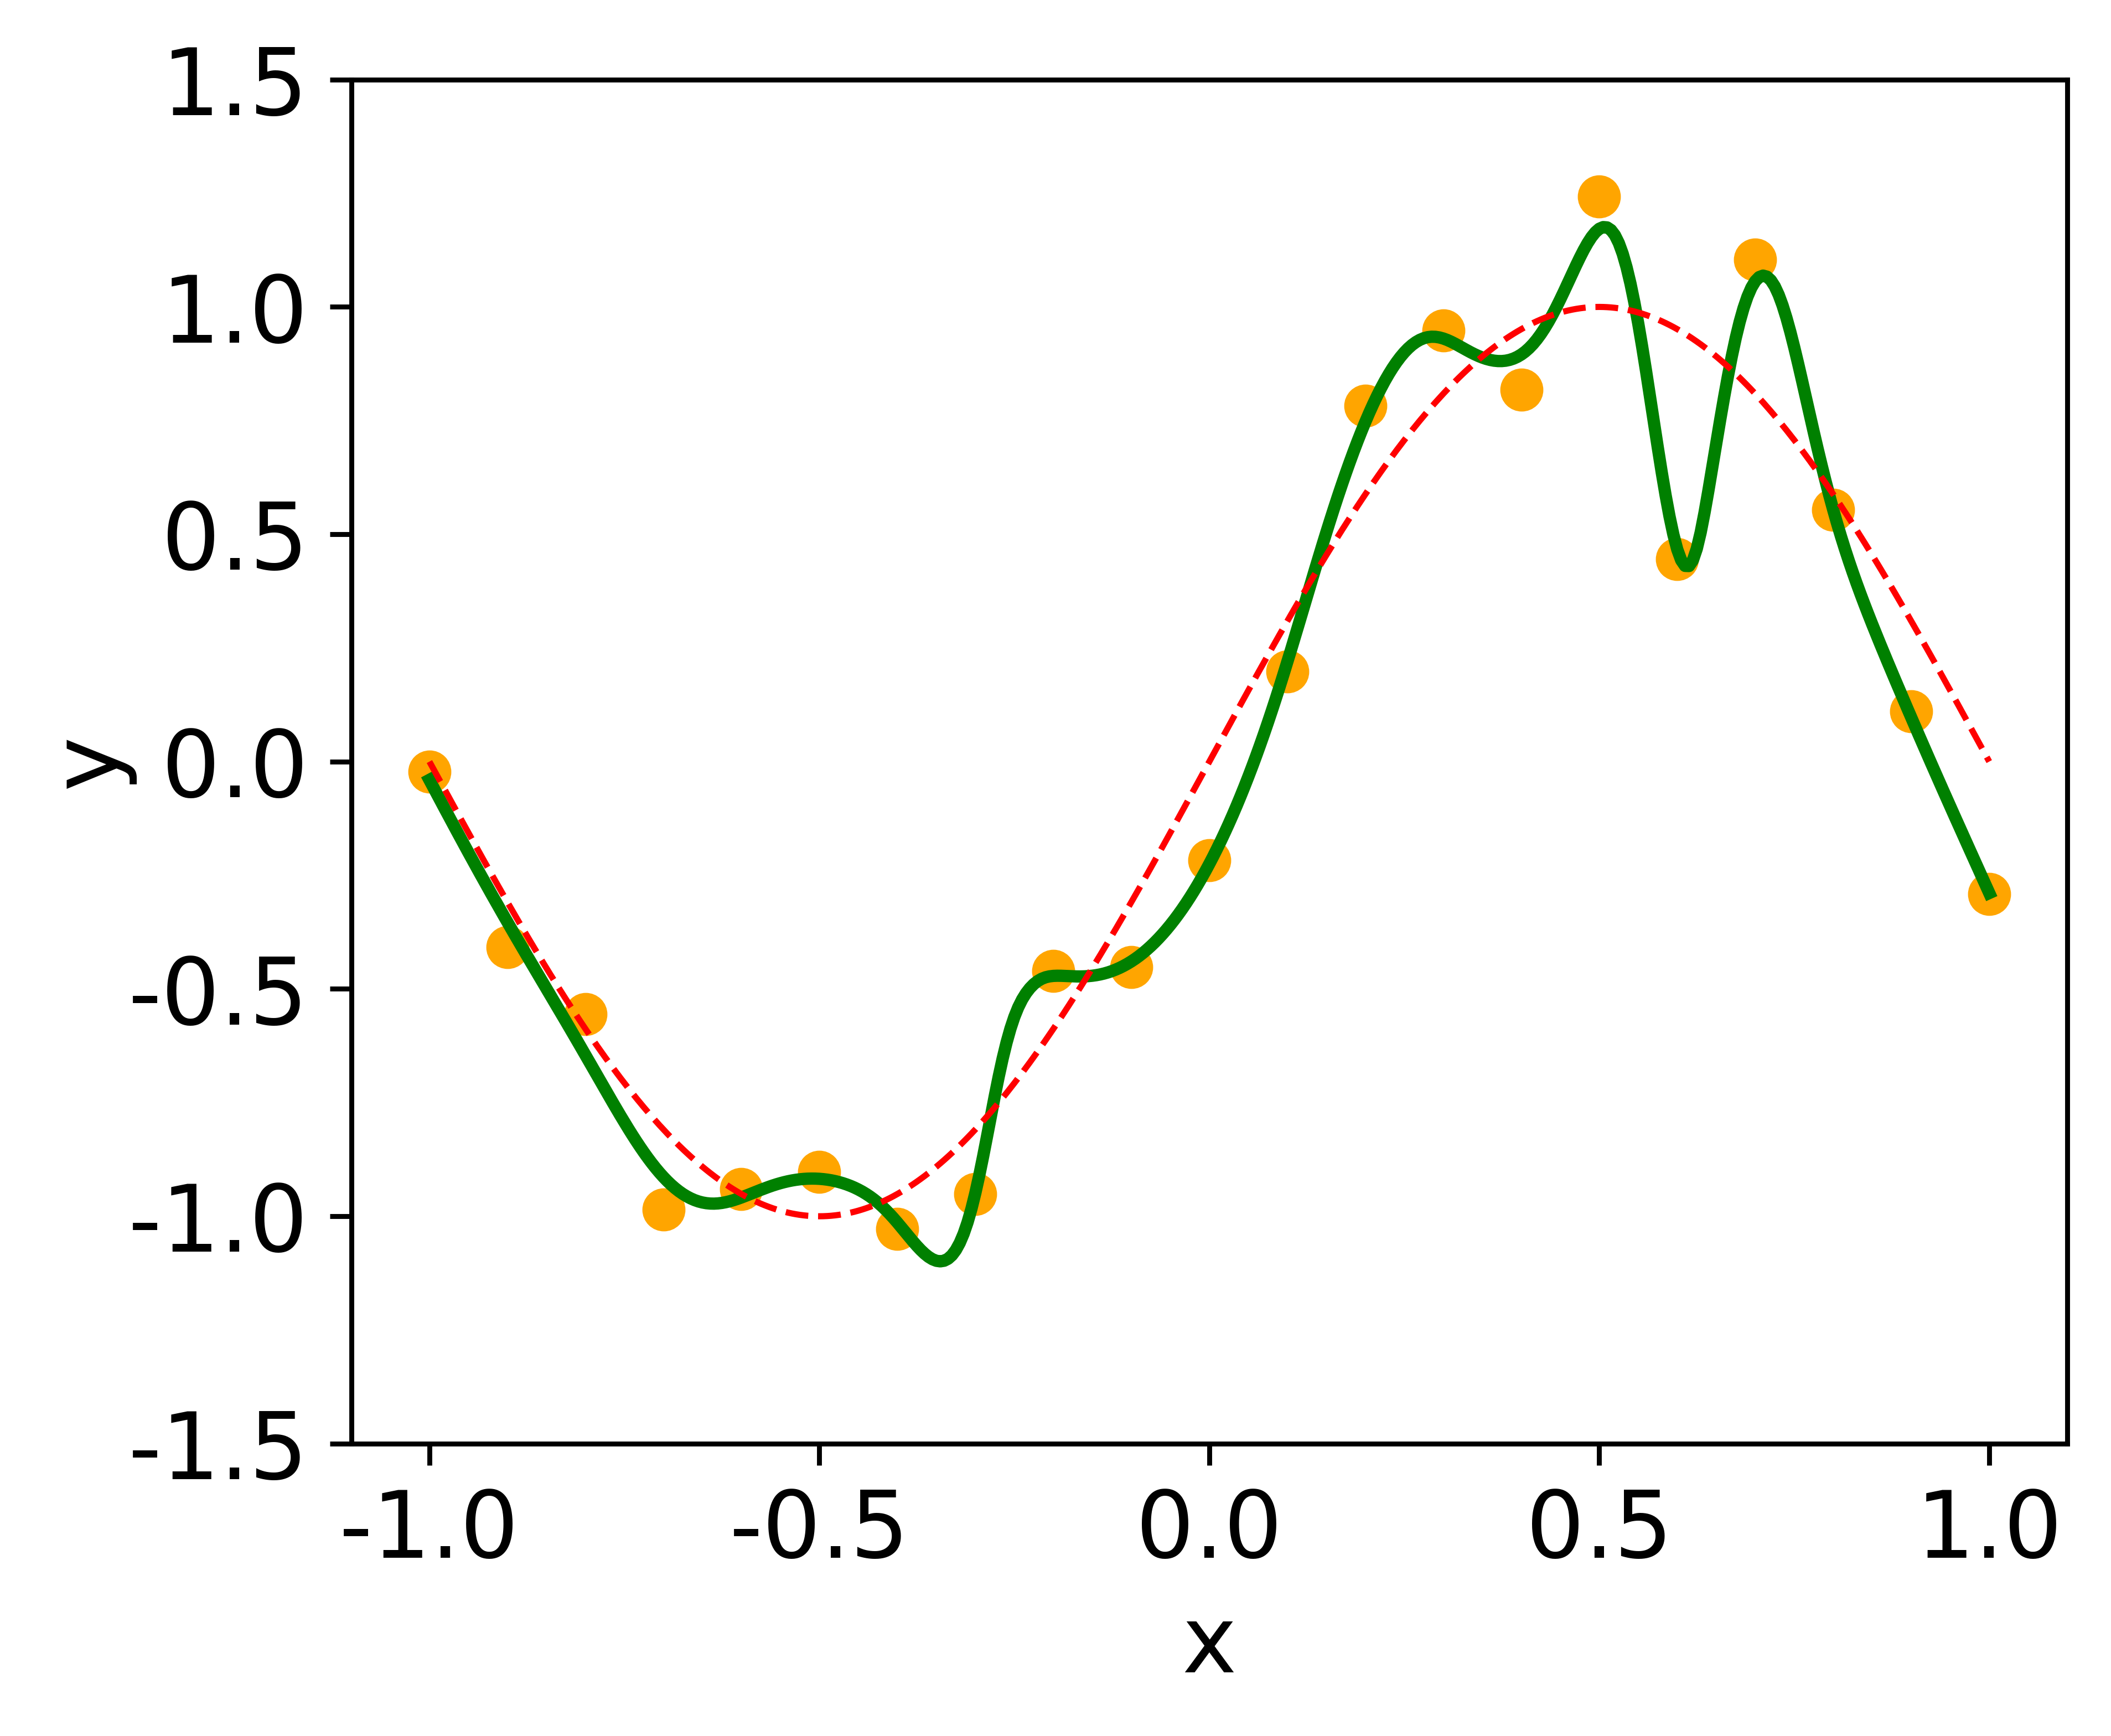

In [39]:
#now, we have the optimal noise sigma=.....
#so,
sigma_opt = 0.009319282062245068
losses = []  # 用于存储每次训练的损失，共NJnum个
output = torch.zeros(inputx.shape).to(device)

for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    x_noisy = xtrain + sigma_opt * torch.randn(xtrain.size()).to(device)
    ytrain = ytrain.to(device)
    
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x_noisy)
        loss = loss_func(prediction, ytrain)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(xtrain.data.numpy(), ytrain.data.numpy(), color="orange")

ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')